### DC Power Flow Solver

In [1]:
# import necessary libaries and data files
import numpy as np
from data import datas
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#load data and manupulate datas if needed
bus_data, line_data, load_data, gen_data, wind_data = datas() #data loading

line_data = pd.DataFrame(line_data).sort_values(by=[0,1]).values #line data sorting and data type change

bus_data = pd.DataFrame(bus_data).sort_values(by = [0]).values #Bus data sorting and data type change

load_data = pd.DataFrame(load_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Load data sorting and data type change

gen_data = pd.DataFrame(gen_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Generation data sorting and data type change

wind_data = pd.DataFrame(wind_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Wind Generation data sorting and data type change


base_mva = 100
R = line_data[:, 2]
X = line_data[:, 3]
B = 0.5j * line_data[:, 4]
taps = line_data[:,5]
Bsh = 1j* bus_data[:, 3]
Z = R + 1j * X
Y = 1 / Z
nline = len(line_data[:, 0])
nbus = int(np.amax(line_data[:, :2]))  # Total Number of buses



In [2]:
def tap_handle(x):
    '''Function to handle transformer tap ratio'''
    if np.real(x) == 0:
        return 1
    else:
        return 1
    

# Y Bus Formation
def Y_bus():
    '''Function to create Y Bus matrix '''
    Ybus = np.zeros((nbus, nbus), dtype=complex)
    Y1 = np.zeros((73, 73), dtype=complex)
    np.fill_diagonal(Y1,Bsh)
    
    for k in range(nline):
        # Off Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 1]) - 1] -= (Y[k])/np.conj(tap_handle(taps[k]))
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 0]) - 1] -= (Y[k])/tap_handle(taps[k])

        # Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 0]) - 1] += (Y[k] + B[k])/pow(abs(tap_handle(taps[k])),2)
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 1]) - 1] += Y[k] + B[k]
    
    Y_bus_ = Ybus + Y1
    return Y_bus_

In [3]:
#Data from Bus_data
bus_no = bus_data[:, 0].astype(int)
bus_type = bus_data[:,1].astype(int)

#Data from Load_data
pl = np.zeros(nbus)
pf = np.zeros(nbus)
delta = np.zeros(nbus)
for k in load_data.index:
    pl[k-1] = load_data.loc[k, 2]/base_mva #base power
    pf[k-1] = load_data.loc[k, 1]
ql = pl * np.tan(np.arccos(pf))

#From Generation Data
pg_ = np.zeros(nbus)
#qg = np.zeros(nbus)
vmag = np.ones(nbus)
#qmin = np.zeros(nbus)
#qmax = np.zeros(nbus)
for k in gen_data.index:
    pg_[k-1] = (gen_data.loc[k, 4]).sum()/base_mva
    vmag[k-1] = np.mean(gen_data.loc[k, 3])
    #qmin[k-1] = gen_data.loc[k, 2].sum()
    #qmax[k-1] = gen_data.loc[k, 1].sum()

# From Wind Data
pwg = np.zeros(nbus)
for k in wind_data.index:
    pwg[k-1] = (wind_data.loc[k, 4])/base_mva

pg = pg_ + pwg
b_data = pd.DataFrame()
b_data['Bus_No'] = bus_no
b_data['Bus_type'] = bus_type
b_data['Pg'] = pg
#b_data['Qg'] = qg
b_data['Pl'] = pl
#b_data['Ql'] = ql
b_data['Vmag'] = vmag
b_data['Delta'] = delta
#b_data['Qmin'] = qmin/base_mva
#b_data['Qmax'] = qmax/base_mva
b_data["P_sh"] = b_data["Pg"] - b_data["Pl"]
#b_data["Q_sh"] = b_data["Qg"] - b_data["Ql"]
b_data = b_data.set_index('Bus_No')

In [4]:
def dc_pf(df):
    P = df.loc[(np.where(df['Bus_type'] != 3)[0] + 1), 'P_sh']
    B = np.imag(Y_bus())[np.where(df['Bus_type'] != 3)[0], :][:, np.where(df['Bus_type'] != 3)[0]]
    delta = -np.dot(np.linalg.inv(B),P)
    df.loc[(np.where(df['Bus_type'] != 3)[0] + 1), 'Delta'] = delta
    return df

In [7]:
dc = dc_pf(b_data)
dc

,Bus_type,Pg,Pl,Vmag,Delta,P_sh
Bus_No,,,,,,
1,2,0.5282,0.5635,1.035,-0.617536,-0.0353
2,1,0.0000,0.5041,1.035,-0.625399,-0.5041
3,1,0.0000,0.9342,1.000,-0.446089,-0.9342
4,1,0.0000,0.3855,1.000,-0.602949,-0.3855
5,1,0.0000,0.3707,1.000,-0.619485,-0.3707
...,...,...,...,...,...,...
69,2,4.0000,0.0000,1.050,-0.603858,4.0000
70,1,0.0000,0.0000,1.050,-0.619558,0.0000
71,2,0.5424,0.0000,1.050,-0.520623,0.5424


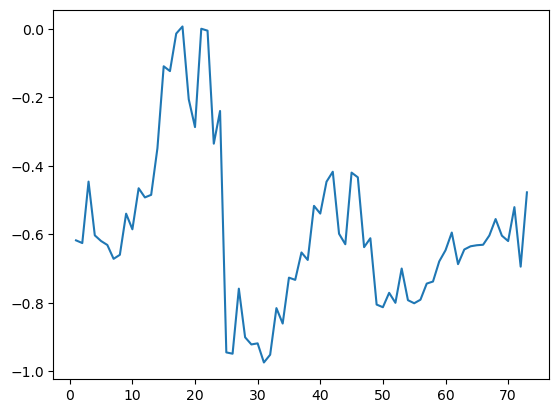

In [8]:
plt.plot(dc.index, dc['Delta'])